In [0]:
#----- Importing the required libraries -----#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pyspark.sql.functions import input_file_name, regexp_extract, split, col, monotonically_increasing_id, floor, concat_ws, count, to_timestamp, size, hour, when, pandas_udf, PandasUDFType, collect_list, struct 
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType, IntegerType
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d

### Data Preprocessing

The above block processes raw `.plt` files from the Geolife dataset to extract usable spatiotemporal trajectory data:

- **Reading Raw Files:** Loads all trajectory files as plain text from the dataset directory using Spark.
- **Metadata Removal:** Filters out non-data rows that are part of the `.plt` file headers (e.g., `WGS`, `Altitude`, etc.).
- **Column Parsing:** Splits each valid line into structured fields: latitude, longitude, altitude, date, and time.
- **Extracting IDs:** Uses regular expressions to extract `user_id` and `traj_id` from the file paths.
- **Timestamp Construction:** Merges the `date` and `time` columns into a single `timestamp` column for time-based processing.
- **Cleanup & Optimization:** Drops the original `date` and `time` columns and caches the result for improved performance in subsequent operations.

In [0]:
#----- Data Preprocessing -----#

# Reading all .plt files as raw text
raw = spark.read.text("dbfs:/FileStore/shared_uploads/psxss41@nottingham.ac.uk/Geolife Trajectories 1.3/Data/*/Trajectory/*.plt") \
    .withColumn("file_path", input_file_name())

# Filtering out the first 6 lines (metadata) using known metadata prefixes
filtered = raw.filter(~raw["value"].startswith("WGS")) \
              .filter(~raw["value"].startswith("Altitude")) \
              .filter(~raw["value"].startswith("Reserved")) \
              .filter(~raw["value"].startswith("0,2,255"))

# Spliting the lines into columns
parsed = filtered.withColumn("split", split(col("value"), ",")) \
                 .filter(size(col("split")) == 7) \
                 .select(
                     col("file_path"),
                     col("split")[0].cast("double").alias("lat"),
                     col("split")[1].cast("double").alias("lon"),
                     col("split")[3].cast("double").alias("altitude"),
                     col("split")[5].alias("date"),
                     col("split")[6].alias("time")
                 )

# Extracting user_id and traj_id from file_path
df = parsed.withColumn("user_id", regexp_extract("file_path", r"Data/(\d{3})/", 1)) \
                 .withColumn("traj_id", regexp_extract("file_path", r"Trajectory/([^/]+\.plt)", 1)) \
                 .drop("file_path")

# Creating a timestamp
df = df.withColumn("timestamp", to_timestamp(concat_ws(" ", "date", "time"), "yyyy-MM-dd HH:mm:ss"))
df = df.drop("date", "time")

# Caching the result for performance
df.cache().show(10)

+---------+----------+--------+-------+------------------+-------------------+
|      lat|       lon|altitude|user_id|           traj_id|          timestamp|
+---------+----------+--------+-------+------------------+-------------------+
|39.894227|116.314732|   492.0|    135|20090124065103.plt|2009-01-24 06:51:03|
|39.893738|116.314578|   492.0|    135|20090124065103.plt|2009-01-24 06:51:05|
|39.893912|116.314656|   492.0|    135|20090124065103.plt|2009-01-24 06:51:07|
|39.893986|116.314658|   492.0|    135|20090124065103.plt|2009-01-24 06:51:09|
|39.894005|116.314607|   492.0|    135|20090124065103.plt|2009-01-24 06:51:14|
|39.894235|116.314686|   491.0|    135|20090124065103.plt|2009-01-24 06:51:19|
|39.894316|116.314719|   491.0|    135|20090124065103.plt|2009-01-24 06:51:20|
|39.894431|116.314778|   491.0|    135|20090124065103.plt|2009-01-24 06:51:21|
|39.894967|116.315027|   491.0|    135|20090124065103.plt|2009-01-24 06:51:23|
|39.895012|116.315051|   491.0|    135|2009012406510

### Filtering Short Trajectories

This block ensures data quality by removing trajectories that are too short to be meaningful:

- **Identifying Short Trajectories:** Counts the number of GPS points in each trajectory. Any trajectory with fewer than 10 points is considered too short.
- **Filtering Criteria:** Retains only those trajectories that have **at least 10 data points**, as they provide enough information for meaningful clustering or analysis.
- **Joining Back:** The original DataFrame is filtered to include only data points from the valid (longer) trajectories.

This step helps reduce noise and improves the effectiveness of downstream trajectory clustering.

In [0]:
# Counting points per trajectory
short_trajs = df.groupBy("user_id", "traj_id").count().filter("count < 10")
print(f"Short trajectories: {short_trajs.count()}")

# Identifying trajectory segments that have at least 10 points
valid_traj_ids = df.groupBy("user_id", "traj_id").count().filter("count >= 10")

# Keeping only those rows in the original DataFrame that belong to valid trajectory segments
df = df.join(valid_traj_ids.select("user_id", "traj_id"), on=["user_id", "traj_id"])

Short trajectories: 98


### Assigning Dynamic Spatial Zones

This section assigns each GPS point in the dataset to a dynamically computed spatial grid zone:

- A bounding box is defined to cover the latitude and longitude extent of the data (`lat_min` to `lat_max`, `lon_min` to `lon_max`).
- This area is divided into a configurable number of latitude and longitude zones (`num_lat_zones × num_lon_zones`).
- Each point is assigned a `zone_lat` and `zone_lon` based on its geographic coordinates.
- A combined `zone` column is created using both `zone_lat` and `zone_lon` to uniquely identify each grid cell.

This zoning helps in efficiently analyzing spatial patterns and enables zone-based clustering or partitioning.

In [0]:
def assign_dynamic_zones(df, lat_min, lat_max, lon_min, lon_max, num_lat_zones, num_lon_zones):
    # Calculating the step size for latitude and longitude zones
    lat_step = (lat_max - lat_min) / num_lat_zones
    lon_step = (lon_max - lon_min) / num_lon_zones

    # Assigning each GPS point to a latitude and longitude zone based on its position
    return df.withColumn("zone_lat", floor((col("lat") - lat_min) / lat_step)) \
             .withColumn("zone_lon", floor((col("lon") - lon_min) / lon_step)) \
             .withColumn("zone", concat_ws("_", col("zone_lat"), col("zone_lon")))

# Defining bounding box and grid size
lat_min, lat_max = 39.5, 40.5
lon_min, lon_max = 115.5, 116.8
num_lat_zones = 10
num_lon_zones = 10

# Applying zone assignment
df = assign_dynamic_zones(df, lat_min, lat_max, lon_min, lon_max, num_lat_zones, num_lon_zones)

# Verifying zone columns exist
df.select("lat", "lon", "zone_lat", "zone_lon", "zone").show(5)

+---------+----------+--------+--------+----+
|      lat|       lon|zone_lat|zone_lon|zone|
+---------+----------+--------+--------+----+
|39.709669|116.335468|       2|       6| 2_6|
|39.709395|116.335742|       2|       6| 2_6|
|39.709132|116.336065|       2|       6| 2_6|
|39.708881| 116.33636|       2|       6| 2_6|
|39.708621|116.336662|       2|       6| 2_6|
+---------+----------+--------+--------+----+
only showing top 5 rows



### Assigning Time Windows to Trajectory Points

This block adds temporal context to each GPS point by assigning a part-of-day label:

- The `hour` is extracted from the timestamp.
- Based on the hour, a `time_window` column is added:
  - **Morning**: 5 AM to 11:59 AM
  - **Afternoon**: 12 PM to 4:59 PM
  - **Evening**: 5 PM to 8:59 PM
  - **Night**: 9 PM to 4:59 AM

These labels help in analyzing user movement patterns across different parts of the day.

In [0]:
# Assigning a part of day label based on the hour
df = df.withColumn("hour", hour("timestamp")) \
       .withColumn("time_window", when((col("hour") >= 5) & (col("hour") < 12), "Morning")
                                 .when((col("hour") >= 12) & (col("hour") < 17), "Afternoon")
                                 .when((col("hour") >= 17) & (col("hour") < 21), "Evening")
                                 .otherwise("Night"))

### Research Question 1  
**How does TRACLUS compare to DBSCAN in terms of clustering quality for trajectory data?**

---

This section implements and evaluates two trajectory clustering algorithms—**DBSCAN** and **TRACLUS**—to compare their effectiveness on GPS trajectory datasets.

1. **DBSCAN Implementation**
   - Applied directly on GPS coordinates.
   - Grouped points by spatial zones.
   - Used clustering quality metrics: **Silhouette Score**, **Number of Clusters**, and **Noise Ratio**.
   - Execution time recorded for runtime comparison.

2. **TRACLUS Implementation**
   - Trajectories were **segmented** using the **Minimum Description Length (MDL)** principle.
   - Extracted line segments were clustered based on start and end coordinates.
   - Same metrics as DBSCAN were computed for comparison.

3. **Evaluation Metrics**
   - **Silhouette Score**: Indicates clustering cohesion and separation.
   - **Noise Ratio**: Percentage of unclustered (noise) points.
   - **Runtime**: Total execution time to evaluate computational efficiency.
   - **Number of Clusters**: Indicates clustering granularity.

This directly addresses **Research Question 1** by quantitatively comparing DBSCAN and TRACLUS based on clustering quality and computational efficiency, allowing for insights into which algorithm performs better for spatial trajectory datasets.

### DBSCAN Clustering on a Spatial Zone

This block performs DBSCAN clustering on a specific zone (`zone_lat = 3`, `zone_lon = 7`) from the trajectory data.

- **DBSCAN Parameters**: `eps = 0.004`, `min_samples = 5`
- A custom `pandas_udf` is defined to run DBSCAN on each partition (zone group).
- The clustering is applied only to data points in zone 3_7.

The results include latitude, longitude, cluster IDs, and relevant metadata for each point.

### Evaluating DBSCAN Clustering Performance

Once clustering is complete, the following performance metrics are computed:

- **Runtime**: Total time taken to apply DBSCAN.
- **Silhouette Score**: Calculated on a 5% sample (if at least 2 clusters exist).
- **Noise Ratio**: Fraction of points marked as noise (`cluster_id = -1`).
- **Number of Clusters**: Unique clusters detected (excluding noise).

These metrics are stored in a dictionary `dbscan_result` for further comparison or reporting.

In [0]:
#----- DBScan -----#
# Defining schema matching what the DBSCAN UDF returns
schema = StructType([
    StructField("user_id", StringType()),
    StructField("traj_id", StringType()),
    StructField("lat", DoubleType()),
    StructField("lon", DoubleType()),
    StructField("timestamp", TimestampType()),
    StructField("zone_lat", IntegerType()),
    StructField("zone_lon", IntegerType()),
    StructField("cluster_id", IntegerType())
])

# DBSCAN UDF function
def create_dbscan_udf(eps_val=0.004, min_samples_val=5):
    @pandas_udf(schema, functionType=PandasUDFType.GROUPED_MAP)
    def run_dbscan(pdf: pd.DataFrame) -> pd.DataFrame:
        coords = pdf[["lat", "lon"]].to_numpy()

        if len(coords) >= min_samples_val:
            db = DBSCAN(eps=eps_val, min_samples=min_samples_val).fit(coords)
            pdf["cluster_id"] = db.labels_
        else:
            pdf["cluster_id"] = -1

        return pdf[["user_id", "traj_id", "lat", "lon", "timestamp", "zone_lat", "zone_lon", "cluster_id"]]
    
    return run_dbscan

# Setting DBSCAN parameters
eps_val = 0.004
min_samples_val = 5
dbscan_udf = create_dbscan_udf(eps_val, min_samples_val)

# Tracking time
start_time = time.time()

# Applying DBSCAN to a filtered zone
result = df.filter((col("zone_lat") == 3) & (col("zone_lon") == 7)) \
           .groupBy("zone_lat", "zone_lon") \
           .apply(dbscan_udf)

result.cache()

# End time after clustering
end_time = time.time()

# Computing cluster quality metrics
total_points = result.count()
noise_points = result.filter("cluster_id == -1").count()
num_clusters = result.select("cluster_id").distinct().filter("cluster_id != -1").count()
noise_ratio = noise_points / total_points if total_points > 0 else 0.0

# Computing silhouette score on sample
sample = result.filter("cluster_id != -1").sample(fraction=0.05).toPandas()
if sample["cluster_id"].nunique() >= 2:
    coords = StandardScaler().fit_transform(sample[["lat", "lon"]])
    sil_score = silhouette_score(coords, sample["cluster_id"])
else:
    sil_score = -1

# Storing in dictionary
dbscan_result = {
    "algorithm": "DBSCAN",
    "eps": eps_val,
    "min_samples": min_samples_val,
    "runtime_sec": round(end_time - start_time, 2),
    "silhouette": round(sil_score, 4),
    "noise_ratio": round(noise_ratio, 4),
    "num_clusters": num_clusters
}

# Output result
print(dbscan_result)

{'algorithm': 'DBSCAN', 'eps': 0.004, 'min_samples': 5, 'runtime_sec': 4.39, 'silhouette': 0.3208, 'noise_ratio': 0.0, 'num_clusters': 6}


### TRACLUS Clustering with Trajectory Segmentation

This cell performs TRACLUS-style trajectory clustering using a two-phase approach:

1. **Trajectory Partitioning**  
   - Each trajectory is split into line segments using the **Minimum Description Length (MDL)** principle.
   - The `mdl_partition` function identifies change points by computing the average perpendicular distance between actual points and their approximated segment.

2. **Segment Clustering**  
   - Segments are then clustered using DBSCAN based on their start and end coordinates.
   - A `pandas_udf` applies DBSCAN per user group, returning a cluster label for each segment.

3. **Evaluation**  
   - The runtime is tracked for performance comparison.
   - A Silhouette Score is computed on a 10% sample (if there are at least 2 clusters), providing a measure of cluster quality.

This method is useful for detecting patterns in movement behavior by analyzing how segments of different trajectories group spatially.

In [0]:
# TRACLUS
# Functions for segmentation
def point_line_distance(p, a, b):
    a, b, p = np.array(a), np.array(b), np.array(p)
    if np.all(a == b):
        return np.linalg.norm(p - a)
    return np.linalg.norm(np.cross(b - a, a - p)) / np.linalg.norm(b - a)

def mdl_partition(trajectory, threshold=0.0005):
    if len(trajectory) < 2:
        return []
    segments = []
    start_idx = 0
    while start_idx < len(trajectory) - 1:
        end_idx = start_idx + 1
        while end_idx < len(trajectory):
            start = (trajectory[start_idx]["lat"], trajectory[start_idx]["lon"])
            end = (trajectory[end_idx]["lat"], trajectory[end_idx]["lon"])
            error = sum(
                point_line_distance((p["lat"], p["lon"]), start, end)
                for p in trajectory[start_idx+1:end_idx]
            ) / (end_idx - start_idx)
            if error > threshold:
                break
            end_idx += 1
        segments.append((trajectory[start_idx], trajectory[end_idx-1]))
        start_idx = end_idx - 1
    return segments

# Segment extraction UDF
segment_schema = StructType([
    StructField("user_id", StringType()),
    StructField("traj_id", StringType()),
    StructField("lat_start", DoubleType()),
    StructField("lon_start", DoubleType()),
    StructField("lat_end", DoubleType()),
    StructField("lon_end", DoubleType())
])

@pandas_udf(segment_schema, functionType=PandasUDFType.GROUPED_MAP)
def extract_segments(pdf: pd.DataFrame) -> pd.DataFrame:
    segments = []
    for _, row in pdf.iterrows():
        for seg in mdl_partition(row["trajectory"]):
            segments.append({
                "user_id": row["user_id"],
                "traj_id": row["traj_id"],
                "lat_start": seg[0]["lat"],
                "lon_start": seg[0]["lon"],
                "lat_end": seg[1]["lat"],
                "lon_end": seg[1]["lon"]
            })
    return pd.DataFrame(segments)

# Segment clustering UDF
segment_cluster_schema = StructType([
    StructField("user_id", StringType()),
    StructField("traj_id", StringType()),
    StructField("lat_start", DoubleType()),
    StructField("lon_start", DoubleType()),
    StructField("lat_end", DoubleType()),
    StructField("lon_end", DoubleType()),
    StructField("cluster_id", IntegerType())
])

@pandas_udf(segment_cluster_schema, functionType=PandasUDFType.GROUPED_MAP)
def cluster_segments(pdf: pd.DataFrame) -> pd.DataFrame:
    coords = pdf[["lat_start", "lon_start", "lat_end", "lon_end"]].to_numpy()
    if len(coords) >= 5:
        coords_scaled = StandardScaler().fit_transform(coords)
        model = DBSCAN(eps=2.0, min_samples=2).fit(coords_scaled)
        pdf["cluster_id"] = model.labels_
    else:
        pdf["cluster_id"] = -1
    return pdf

# start_time = time.time()
# Execution Pipeline
# Filter input DataFrame df (must be defined) to desired zones
filtered_df = df.filter((col("zone_lat").isin([3])) & (col("zone_lon").isin([7])))

# Creating trajectory arrays
trajectory_df = filtered_df.orderBy("timestamp").groupBy("user_id", "traj_id") \
    .agg(collect_list(struct("lat", "lon", "timestamp")).alias("trajectory"))

# Applying segment extraction
segment_df = trajectory_df.groupby("user_id", "traj_id").apply(extract_segments)

# Applying segment clustering
clustered_segments = segment_df.groupby("user_id").apply(cluster_segments)
clustered_segments.cache()
clustered_segments.count()

# Noise Ratio Calculation
total_segments = clustered_segments.count()
noise_segments = clustered_segments.filter("cluster_id == -1").count()
noise_ratio = round(noise_segments / total_segments, 4) if total_segments > 0 else 0.0

runtime_sec = time.time() - start_time

# Evaluation
sample = clustered_segments.filter("cluster_id != -1").sample(fraction=0.1).toPandas()
if sample["cluster_id"].nunique() >= 2:
    coords = sample[["lat_start", "lon_start", "lat_end", "lon_end"]].to_numpy()
    coords_scaled = StandardScaler().fit_transform(coords)
    sil_score = silhouette_score(coords_scaled, sample["cluster_id"])
else:
    sil_score = -1

print(f"TRACLUS Silhouette Score: {sil_score:.4f}")

TRACLUS Silhouette Score: 0.1272


In [0]:
# 6. Collect TRACLUS evaluation results in a dictionary
traclus_results = {
    "method": "TRACLUS",
    "zone_lat": 3,
    "zone_lon": 7,
    "eps": 4.0,                # from DBSCAN clustering step
    "min_samples": 3,          # from DBSCAN clustering step
    "runtime": runtime_sec,
    "num_segments": clustered_segments.count(),
    "num_clusters": clustered_segments.select("cluster_id").distinct().count(),
    "silhouette": round(sil_score, 4),
    "noise_ratio": round(noise_ratio, 4)
}

print("\nTRACLUS Results Dictionary:")
print(traclus_results)


TRACLUS Results Dictionary:
{'method': 'TRACLUS', 'zone_lat': 3, 'zone_lon': 7, 'eps': 4.0, 'min_samples': 3, 'runtime': 4977.776783704758, 'num_segments': 921, 'num_clusters': 4, 'silhouette': 0.1272, 'noise_ratio': 0.0695}


### Research Question 2  
**How do different Spark partitioning strategies (region, user ID, time) affect performance and clustering outcomes?**

---

This block evaluates the effect of different partitioning strategies on the performance and quality of DBSCAN clustering over trajectory data. Here's what each part of the code does:

1. **Schema Definition**  
   A structured schema is defined to match the output of the DBSCAN clustering function, which includes user ID, trajectory ID, location coordinates, timestamp, partition key, and cluster ID.

2. **DBSCAN UDF Creation**  
   A `make_dbscan_udf` function wraps a custom DBSCAN clustering implementation in a `pandas_udf`. It scales the coordinates and clusters the points within each group defined by the chosen partition key.

3. **Partition Key Assignment**  
   The `add_partition_keys` function adds three partitioning strategies to the DataFrame:
   - `region_key`: based on spatial zone grid (`zone_lat` and `zone_lon`)
   - `user_id`: trajectory owner
   - `time_key`: hour-of-day buckets

4. **Evaluation Function**  
   The `evaluate_partitioning` function:
   - Adds the selected partition key to the DataFrame
   - Performs stratified sampling by `partition_key`
   - Applies DBSCAN clustering
   - Computes clustering runtime and silhouette score for quality assessment

5. **Grid Search Execution**  
   The final loop tests combinations of DBSCAN hyperparameters (`eps` and `minpts`) across all three partitioning strategies (`region_key`, `user_id`, `time_key`). For each combination, it:
   - Prints progress
   - Evaluates clustering performance
   - Appends results (including runtime and silhouette score) to a list for analysis

This process helps assess how the choice of data partitioning impacts both computational efficiency and clustering quality.

In [0]:
# Research Question 2
# 1. Define schema
schema = StructType([
    StructField("user_id", StringType()),
    StructField("traj_id", StringType()),
    StructField("lat", DoubleType()),
    StructField("lon", DoubleType()),
    StructField("timestamp", TimestampType()),
    StructField("partition_key", StringType()),
    StructField("cluster_id", IntegerType())
])

# 2. Define DBSCAN UDF
def make_dbscan_udf(eps, minpts):
    def dbscan_udf(pdf: pd.DataFrame) -> pd.DataFrame:
        coords = pdf[["lat", "lon"]].to_numpy()
        if len(coords) >= minpts:
            coords_scaled = StandardScaler().fit_transform(coords)
            model = DBSCAN(eps=eps, min_samples=minpts).fit(coords_scaled)
            pdf["cluster_id"] = model.labels_
        else:
            pdf["cluster_id"] = -1

        # ✅ Keep only schema-matching columns
        return pdf[[
            "user_id", "traj_id", "lat", "lon", "timestamp", "partition_key", "cluster_id"
        ]]
    return dbscan_udf

# 3. Add partition keys
def add_partition_keys(df):
    df = df.withColumn("hour", hour("timestamp"))
    df = df.withColumn("region_key", concat_ws("_", col("zone_lat"), col("zone_lon")))
    df = df.withColumn("time_key", col("hour").cast("string"))
    return df

# 4. Evaluation function
def evaluate_partitioning(df, key_col, eps=0.01, minpts=8, sample_frac=0.1):
    print(f"Evaluating partitioning by: {key_col}")
    start = time.time()
    dbscan_udf = make_dbscan_udf(eps, minpts)

    # Add key and sample early
    df = df.withColumn("partition_key", col(key_col))
    # df_sampled = df.sample(fraction=sample_frac, seed=42)
    df_sampled = df.sampleBy("partition_key", fractions={k: 0.05 for k in df.select("partition_key").distinct().rdd.flatMap(lambda x: x).collect()}, seed=42)

    # Use applyInPandas with explicit schema
    clustered = df_sampled.groupBy("partition_key").applyInPandas(dbscan_udf, schema)
    clustered.cache()
    
    runtime = round(time.time() - start, 2)

    # Evaluate Silhouette Score
    sample = clustered.filter("cluster_id != -1").sample(fraction=0.05).toPandas()
    if sample["cluster_id"].nunique() > 1:
        coords = StandardScaler().fit_transform(sample[["lat", "lon"]])
        sil_score = round(silhouette_score(coords, sample["cluster_id"]), 4)
    else:
        sil_score = -1

    print(f"Runtime: {runtime}s, Silhouette Score: {sil_score}")
    return {"strategy": key_col, "runtime": runtime, "silhouette": sil_score}

# 5. Run
df = add_partition_keys(df)
results = []

for key in ["region_key", "user_id", "time_key"]:
    for eps in [0.001, 0.003, 0.005, 0.01]:
        for minpts in [3, 5, 8, 10]:
            print(f"\nTesting: partition={key}, eps={eps}, minpts={minpts}")
            result = evaluate_partitioning(df, key_col=key, eps=eps, minpts=minpts, sample_frac=0.1)
            result.update({"eps": eps, "minpts": minpts, "partition": key})
            results.append(result)


Testing: partition=region_key, eps=0.001, minpts=3
Evaluating partitioning by: region_key
Runtime: 16.55s, Silhouette Score: -0.3997

Testing: partition=region_key, eps=0.001, minpts=5
Evaluating partitioning by: region_key
Runtime: 14.12s, Silhouette Score: -0.43

Testing: partition=region_key, eps=0.001, minpts=8
Evaluating partitioning by: region_key
Runtime: 14.12s, Silhouette Score: -0.6089

Testing: partition=region_key, eps=0.001, minpts=10
Evaluating partitioning by: region_key
Runtime: 97.82s, Silhouette Score: -0.2749

Testing: partition=region_key, eps=0.003, minpts=3
Evaluating partitioning by: region_key
Runtime: 28.41s, Silhouette Score: -0.511

Testing: partition=region_key, eps=0.003, minpts=5
Evaluating partitioning by: region_key
Runtime: 30.68s, Silhouette Score: -0.5706

Testing: partition=region_key, eps=0.003, minpts=8
Evaluating partitioning by: region_key
Runtime: 14.07s, Silhouette Score: -0.5079

Testing: partition=region_key, eps=0.003, minpts=10
Evaluating 

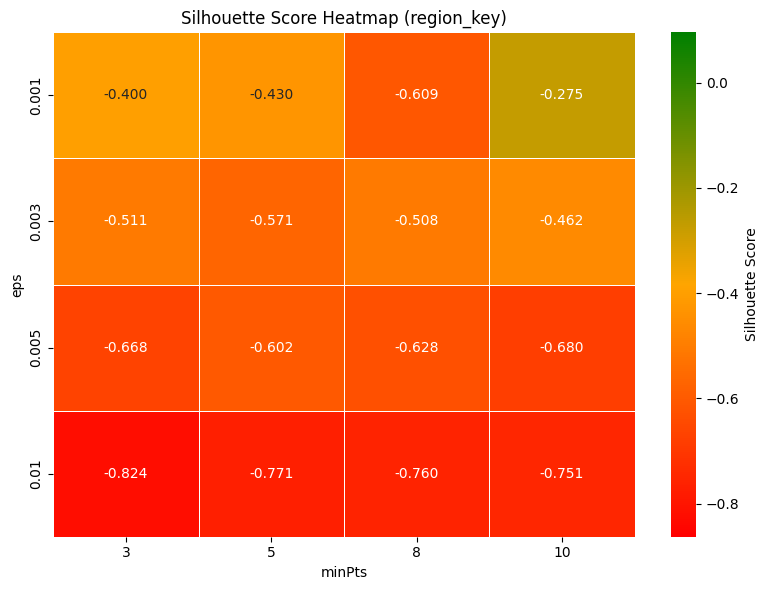

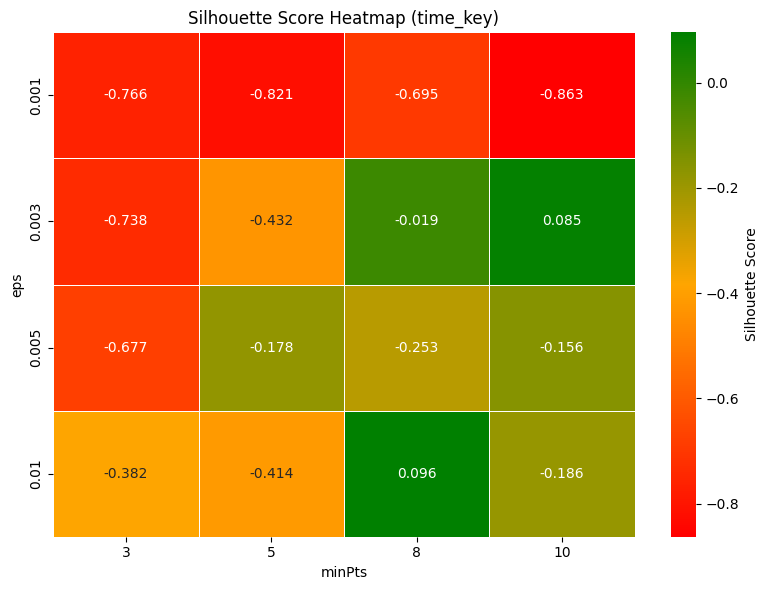

In [0]:
# Research Question 2 - Visualisation
# Custom color map: red (worst) → orange → green (best)
cmap = LinearSegmentedColormap.from_list("custom_heatmap", ["red", "orange", "green"])

# Convert your list of result dicts to DataFrame
df_results = pd.DataFrame(results)

# Filter out user_id partitioning
df_results_filtered = df_results[df_results["partition"] != "user_id"]

# Generate heatmaps for remaining strategies
for strategy in df_results_filtered['partition'].unique():
    pivot = df_results_filtered[df_results_filtered['partition'] == strategy] \
        .pivot(index='eps', columns='minpts', values='silhouette')

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".3f",
        cmap=cmap,
        vmin=df_results_filtered['silhouette'].min(),
        vmax=df_results_filtered['silhouette'].max(),
        linewidths=0.5,
        cbar_kws={'label': 'Silhouette Score'}
    )
    plt.title(f"Silhouette Score Heatmap ({strategy})")
    plt.xlabel("minPts")
    plt.ylabel("eps")
    plt.tight_layout()
    plt.show()

### Research Question 3  
**What is the trade-off between computational efficiency and clustering accuracy when using Euclidean vs DTW in distributed Spark?**

---

This blocks compares the performance and clustering results of DBSCAN using two different distance metrics: **Euclidean** and **Dynamic Time Warping (DTW)**.


1. **DTW Distance Function**  
   A manual implementation of DTW is used to calculate distances between two trajectories by measuring the optimal alignment path.

2. **Interpolation**  
   Since DTW requires equal-length sequences, each trajectory is interpolated to a fixed length (default: 20 points) using linear interpolation.

3. **Clustering Function**  
   A pairwise distance matrix is computed for all trajectories using either:
   - Euclidean distance (fast but sensitive to sequence alignment),
   - or DTW (slower but better for time-series similarity).
   The distance matrix is passed to DBSCAN for clustering.

4. **Evaluation Function**  
   Trajectories are grouped, sampled, clustered, and timed to compare:
   - Runtime (computational efficiency)
   - Number of clusters found (a proxy for clustering granularity)

5. **Final Execution**  
   The evaluation is run separately for both distance metrics. The results are printed for direct comparison of runtime and clustering effectiveness.

This implementation directly addresses **Research Question 3** by providing quantitative insights into the trade-offs between **speed (Euclidean)** and **accuracy (DTW)** in clustering GPS trajectory data on a distributed Spark setup.

In [0]:
# Research Question 3
# 1. DTW Function
def dtw_distance(ts_a, ts_b):
    n, m = len(ts_a), len(ts_b)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            dist = np.linalg.norm(np.array(ts_a[i - 1]) - np.array(ts_b[j - 1]))
            dtw_matrix[i, j] = dist + min(
                dtw_matrix[i - 1, j], dtw_matrix[i, j - 1], dtw_matrix[i - 1, j - 1]
            )
    return dtw_matrix[n, m]

# 2. Interpolation function to resample trajectories
def interpolate_trajectory(traj, target_len=20):
    if len(traj) < 2:
        return [traj[0]] * target_len  # Repeat if not enough points

    traj = np.array(traj)
    original_idx = np.linspace(0, 1, num=len(traj))
    interp_idx = np.linspace(0, 1, num=target_len)

    lat_interp = interp1d(original_idx, traj[:, 0], kind="linear")(interp_idx)
    lon_interp = interp1d(original_idx, traj[:, 1], kind="linear")(interp_idx)

    return list(zip(lat_interp, lon_interp))

# 3. Clustering function
def cluster_trajectories(pdf, use_dtw=False, eps=5.0, min_samples=2):
    trajs = pdf["trajectory"].tolist()
    traj_ids = pdf["traj_id"].tolist()

    # Interpolate to fixed length
    vectors = [interpolate_trajectory([(p["lat"], p["lon"]) for p in traj], 20) for traj in trajs]

    # Distance matrix
    n = len(vectors)
    dists = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            if use_dtw:
                d = dtw_distance(vectors[i], vectors[j])
            else:
                d = np.linalg.norm(np.array(vectors[i]).flatten() - np.array(vectors[j]).flatten())
            dists[i, j] = dists[j, i] = d

    model = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed")
    labels = model.fit_predict(dists)

    return pd.DataFrame({
        "traj_id": traj_ids,
        "cluster_id": labels
    })

# 4. Evaluation function
def evaluate_trajectory_clustering(df, use_dtw=False, sample_frac=0.1, eps=5.0, min_samples=2):
    start = time.time()
    traj_df = df.groupBy("traj_id").agg(
        collect_list(struct("lat", "lon", "timestamp")).alias("trajectory")
    ).sample(fraction=sample_frac, seed=42)

    pdf = traj_df.toPandas()
    clustered_df = cluster_trajectories(pdf, use_dtw=use_dtw, eps=eps, min_samples=min_samples)

    runtime = round(time.time() - start, 2)
    n_clusters = len(set(clustered_df["cluster_id"])) - (1 if -1 in clustered_df["cluster_id"] else 0)

    print(f"{'DTW' if use_dtw else 'Euclidean'} Runtime: {runtime}s, Clusters: {n_clusters}")
    return clustered_df, runtime

# 5. Run evaluations
euclidean_result, euclidean_time = evaluate_trajectory_clustering(df, use_dtw=False, eps=10.0)
dtw_result, dtw_time = evaluate_trajectory_clustering(df, use_dtw=True, eps=10.0)

Euclidean Runtime: 97.55s, Clusters: 9
DTW Runtime: 335.36s, Clusters: 8
